In [1]:
execution_mode = 'full'

# Decision Tree Model

The first model to be trained with supervised learning is to be a Decision Tree Classifier, compare [[JudACaps](./A_References.ipynb#judacaps)]. This chapter shows the training and the performance measurement of two Ensemble models. First, a simple Decision Tree Classifier is trained without cross-validation, then the classifier will be statistically hardened with the help of cross-validation. As a second Ensemble classifier, a Random Forests will be trained and its performance tested.

## Table of Contents

- [Data Takeover](#Data-Takeover)
- [Decision-Tree Classifier](#Decision-Tree-Classifier)
    - [Train/Test Split for Decision Tree](#Train/Test-Split-for-Decision-Tree)
    - [Model Training for Decision Tree](#Model-Training-for-Decision-Tree)
    - [Performance Measurement of Decision Tree](#Performance-Measurement-of-Decision-Tree)
- [Decision Tree Classifier with Cross-Validation](#Decision-Tree-Classifier-with-Cross-Validation)
    - [Train/Test Split for Decision Tree CV](#Train/Test-Split-for-Decision-Tree-CV)
    - [Model Training for Decision Tree CV](#Model-Training-for-Decision-Tree-CV)
    - [Performance Measurement of Decision Tree CV](#Performance-Measurement-of-Decision-Tree-CV)
- [Random Forests](#Random-Forests)
    - [Train/Test Split for Random Forests](#Train/Test-Split-for-Random-Forests)
    - [Model Training for Random Forests](#Model-Training-for-Random-Forests)
    - [Performance Measurement of Random Forests](#Performance-Measurement-of-Random-Forests)
    - [Model Interpretation of Random Forests](#Model-Interpretation-of-Random-Forests)
- [Summary](#Summary)
    - [Results Handover](#Results-Handover)

## Data Takeover

As the first step, the data from previous chapters have to be read in as input for processing in this chapter.

In [2]:
import os
import pandas as pd
import bz2
import _pickle as cPickle

path_goldstandard = './daten_goldstandard'

# Restore results so far
df_labelled_feature_matrix = pd.read_pickle(os.path.join(path_goldstandard,
                                                         'labelled_feature_matrix.pkl'),
                                 compression=None)

# Restore DataFrame with features from compressed pickle file
with bz2.BZ2File((os.path.join(
    path_goldstandard, 'labelled_feature_matrix_full.pkl')), 'rb') as file:
    df_attribute_with_sim_feature = cPickle.load(file)

df_labelled_feature_matrix.head()

coordinate_E_delta  coordinate_N_delta  corporate_full_delta  doi_delta  \
0                -1.0                -1.0                  -1.0       -0.5   
1                -1.0                -1.0                  -1.0       -1.0   
2                -1.0                -1.0                  -0.5       -1.0   
3                -1.0                -1.0                  -1.0       -1.0   
4                -1.0                -1.0                  -0.5       -1.0   

   edition_delta  exactDate_delta  format_prefix_delta  format_postfix_delta  \
0           -1.0            0.500                  1.0              0.111111   
1           -1.0            0.375                  0.0              0.111111   
2           -0.5            0.250                  1.0              1.000000   
3           -1.0            0.750                  1.0              1.000000   
4           -0.5            0.250                  0.0              0.111111   

   isbn_delta  ismn_delta  ...  part_delta  person_100_delta  \
0         1.0        -1.0  ...   -0.500000          0.492677   
1         0.0        -1.0  ...   -1.000000         -0.500000   
2         0.0        -1.0  ...   -1.000000         -0.500000   
3         0.0        -1.0  ...    0.537037          1.000000   
4         0.0        -1.0  ...   -0.500000          1.000000   

   person_700_delta  person_245c_delta  pubinit_delta  scale_delta  \
0         -0.500000           0.501852      -0.500000         -1.0   
1         -0.500000          -0.500000       0.431481         -1.0   
2          0.595726           0.512821      -0.500000         -1.0   
3          0.517857           0.682481      -0.500000         -1.0   
4          0.648301           0.706674      -0.500000         -1.0   

   ttlfull_245_delta  ttlfull_246_delta  volumes_delta  duplicates  
0           0.583840               -1.0           -0.5           0  
1           0.581389               -0.5           -0.5           0  
2           0.527260               -1.0           -0.5           0  
3           0.534578               -1.0            0.0           0  
4           1.000000               -1.0            0.0           0  

[5 rows x 21 columns]

In [3]:
print('Part of duplicates (1) and uniques (0) in units of [%]')
print(round(df_labelled_feature_matrix.duplicates.value_counts(normalize=True)*100, 2))

Part of duplicates (1) and uniques (0) in units of [%]
0    98.59
1     1.41
Name: duplicates, dtype: float64


## Decision Tree Classifier

Decision Tree is the most basic algorithm in the family of Ensemble methods. Its advantage is its clarity. It can be easily interpreted when looking at the trained model tree.

### Train/Test Split for Decision Tree

The train/test split has been implemented as a general function $\texttt{.split}\_\texttt{feature}\_\texttt{target}()$ in a separate library called [classifier_fitting_funcs.py](./classifier_fitting_funcs.py). The function uses the library function $\texttt{sklearn.model}\_\texttt{selection.train}\_\texttt{test}\_\texttt{split}()$ from scikit-learn with a parameter $\texttt{stratify}$ in order to generate a balanced distribution of the two classes in the split data, the same as in the original distribution.

In [4]:
import classifier_fitting_funcs as cff

X_tr, X_val, X_te, y_tr, y_val, y_te, idx_tr, idx_val, idx_te = cff.split_feature_target(
    df_labelled_feature_matrix, 'train_validation_test')

X_tr[:5], y_tr[:5], idx_tr[:5]

(array([[-1.        , -1.        , -1.        , -1.        , -1.        ,
          0.375     ,  1.        ,  1.        ,  0.        , -1.        ,
         -1.        , -0.5       , -0.5       ,  0.53717949,  0.49234099,
          0.48232323, -1.        ,  0.57057231, -1.        ,  0.        ],
        [-1.        , -1.        , -1.        , -1.        , -1.        ,
          0.25      ,  1.        ,  0.42857143,  0.        , -1.        ,
         -1.        , -0.5       , -0.5       , -0.5       , -0.5       ,
         -0.5       , -1.        ,  0.56825397, -1.        ,  0.55555556],
        [-1.        , -1.        , -0.5       , -1.        , -1.        ,
          0.5       ,  1.        ,  1.        ,  0.        , -1.        ,
         -1.        , -0.5       , -0.5       , -0.5       , -0.5       ,
          0.41282051, -1.        ,  0.58290694, -0.5       , -0.5       ],
        [-1.        , -1.        , -0.5       , -1.        , -1.        ,
          0.5       ,  1.        , 

The train/test split is done twice. The first split generates an intermediate set of data for training which consists of 80% and a set of data for testing which consists of 20% of the full data. The second split takes the intermediate training data as its basis and extracts an 80% set out of there which will be used for training the model. The remaining 20% out of the intermediate training data will be used for validating the model during training. This strict separation of the data used for training and used for validating the model conforms to the basic principle of machine learning that any model is to be tested with unseen data. If this principle is hurt and the test data is polluted with data, the model has been in contact with during the training phase, the model runs the risk of bias on validation.

In [5]:
print(X_tr.shape, y_tr.shape, X_val.shape, y_val.shape, X_te.shape, y_te.shape)
print('The test data set holds {:d} records of uniques and {:d} records of duplicates.'.format(
    len(y_te[y_te==0]), len(y_te[y_te==1])))

(66979, 20) (66979,) (16745, 20) (16745,) (20931, 20) (20931,)
The test data set holds 20636 records of uniques and 295 records of duplicates.


### Model Training for Decision Tree

Grid search is to be done with the Decision Tree Classifier. Goal is to find the best parameter set for the classifier. First, the parameter ranges, the grid points in the grid space are defined. In the following code cell, a global parameter $\texttt{execution}\_\texttt{mode}$ for controlling the size of the grid is used. Several run-modes of this notebook are foreseen. The global parameter is set in the very first code cell of this notebook and can be overwritten from outside when the notebook is called by [Overview and Summary](./0_OverviewSummary.ipynb). When called from outside, a larger range of the grid space shall be executed with the goal to get a systematic result of the calculations. The execution of the notebook in its local mode has the goal to be done quickly, just to get a basic idea on how the models behave.

In [6]:
if execution_mode == 'manual' :
    depths = list(range(2, 30, 2)) # The number of features is 20.
    depths.extend([35, 40, 50, None])
    parameter_dictionary = {
        'max_depth' : depths,
        'criterion' : ['gini'],
        'class_weight' : ['balanced']
    }
elif execution_mode == 'full' :
    # Find best parameters of Decision Tree
    depths = list(range(4, 32, 2))
    depths.extend([35, 40, 45, 50, None])
    parameter_dictionary = {
        'max_depth' : depths,
        'criterion' : ['gini', 'entropy'],
        'class_weight' : [None, 'balanced']
    }
elif execution_mode == 'restricted' :
    depths = list(range(16, 26, 2)) # The number of features is 20.
    depths.extend([None])
    parameter_dictionary = {
        'max_depth' : depths,
        'criterion' : ['gini', 'entropy'],
        'class_weight' : [None, 'balanced']
    }
elif execution_mode == 'tune' :
    # Tune parameters of Decision Tree
    depths = list(range(1, 31))
    depths.extend([35, 40, 45, 50, None])
    parameter_dictionary = {
        'max_depth' : depths,
        'criterion' : ['gini', 'entropy'],
        'class_weight' : ['balanced']
    }

# Grid of values
grid = cff.generate_parameter_grid(parameter_dictionary)

The grid parameters are ...
max_depth [4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 35, 40, 45, 50, None]
criterion ['gini', 'entropy']
class_weight [None, 'balanced']
 => Number of combinations : 76


The Decision Tree Classifier is fitted with grid search with the help of a function $\texttt{.fit}\_\texttt{model}\_\texttt{measure}\_\texttt{scores}()$ implemented in library [classifier_fitting_funcs.py](./classifier_fitting_funcs.py). This function takes the model instance as parameter and returns the scores of the fitted model on the validation data.

In [7]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=0)

# Save accuracy on test set
test_scores = []
for params_dict in grid :
    test_scores.append(cff.fit_model_measure_scores(dt, params_dict, X_tr, y_tr, X_val, y_val))

# Save measured accuracies
df_test_scores_dt = pd.DataFrame(test_scores).sort_values('accuracy_val', ascending=False)

Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 4}


 => validation score 99.785%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 6}


 => validation score 99.863%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 8}


 => validation score 99.887%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 10}
 => validation score 99.904%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 12}


 => validation score 99.898%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 14}


 => validation score 99.893%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 16}


 => validation score 99.887%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 18}


 => validation score 99.887%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 20}
 => validation score 99.887%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 22}


 => validation score 99.887%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 24}


 => validation score 99.887%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 26}


 => validation score 99.887%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 28}


 => validation score 99.887%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 30}


 => validation score 99.887%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 35}


 => validation score 99.887%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 40}


 => validation score 99.887%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 45}


 => validation score 99.887%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': 50}
 => validation score 99.887%
Fitting with parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': None}


 => validation score 99.887%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 4}
 => validation score 99.785%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 6}


 => validation score 99.815%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 8}
 => validation score 99.922%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 10}


 => validation score 99.934%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 12}
 => validation score 99.934%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 14}


 => validation score 99.934%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 16}
 => validation score 99.928%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 18}


 => validation score 99.922%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 20}
 => validation score 99.916%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 22}


 => validation score 99.916%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 24}
 => validation score 99.916%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 26}


 => validation score 99.916%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 28}
 => validation score 99.916%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 30}


 => validation score 99.916%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 35}
 => validation score 99.916%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 40}


 => validation score 99.916%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 45}
 => validation score 99.916%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': 50}


 => validation score 99.916%
Fitting with parameters {'class_weight': None, 'criterion': 'entropy', 'max_depth': None}
 => validation score 99.916%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4}


 => validation score 98.794%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6}
 => validation score 99.027%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 8}


 => validation score 99.433%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10}
 => validation score 99.713%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 12}


 => validation score 99.773%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 14}
 => validation score 99.797%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 16}


 => validation score 99.904%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 18}
 => validation score 99.904%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 20}


 => validation score 99.916%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 22}
 => validation score 99.922%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 24}


 => validation score 99.922%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 26}
 => validation score 99.922%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 28}


 => validation score 99.922%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 30}
 => validation score 99.922%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 35}


 => validation score 99.922%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 40}
 => validation score 99.922%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 45}


 => validation score 99.922%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 50}
 => validation score 99.922%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None}


 => validation score 99.922%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 4}
 => validation score 98.818%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 6}


 => validation score 98.710%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 8}
 => validation score 99.236%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10}


 => validation score 99.606%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 12}
 => validation score 99.725%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 14}


 => validation score 99.875%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 16}
 => validation score 99.916%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 18}


 => validation score 99.910%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 20}
 => validation score 99.928%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 22}


 => validation score 99.928%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 24}
 => validation score 99.928%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 26}


 => validation score 99.928%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 28}
 => validation score 99.928%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 30}


 => validation score 99.928%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 35}
 => validation score 99.928%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 40}


 => validation score 99.928%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 45}
 => validation score 99.928%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 50}


 => validation score 99.928%
Fitting with parameters {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None}
 => validation score 99.928%


Naming the missing ($\texttt{None}$) entry of $\texttt{class}\_\texttt{weight}$ 'unbalanced', will make the test score data more speaking.

In [8]:
ts_dict = {}

# kow = kind of weight
for kow in parameter_dictionary['class_weight']:
    ts_dict['unbalanced' if kow is None else kow] = [
        ts for ts in test_scores if ts['class_weight'] == kow]

Plotting the accuracy scores as a function of tree depth, is a way of determining the best tree depth for a Decision Tree Classifier. Very often, the accuracy for the training data increases monotonically with increasing tree depth towards its maximum value. This monotonical increase of the accuracy score is a sign of overfitting with the training data. The accuracy scores calculated with the validation data is expected to show a different behaviour, though. Validating the trained model with the validation data very often shows a distinct maximum value and a decrease of the accuracy score for higher values of tree depth after this maximum. The maximum accuracy score value for the validation data is interpreted as the best value for the tree depth of the best Decision Tree Classifier.

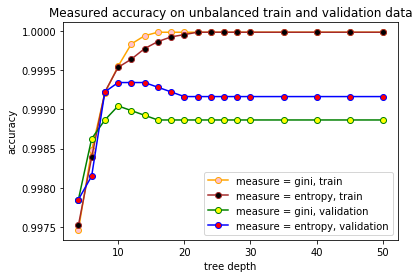

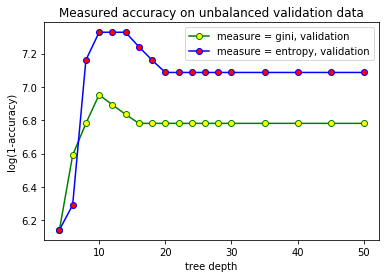

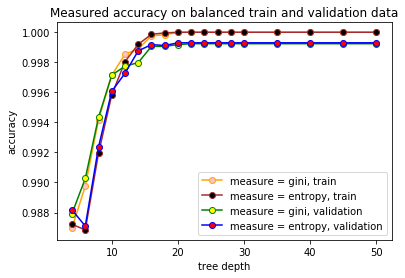

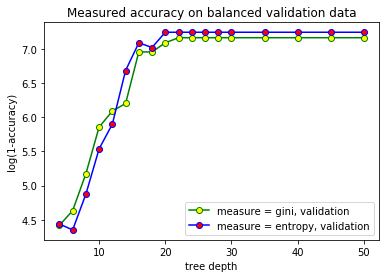

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import results_analysis_funcs as raf

for kow in parameter_dictionary['class_weight'] :
    kind_of_weight = 'unbalanced' if kow is None else kow
    # Train data plot
    plt = raf.plot_accuracy(parameter_dictionary, ts_dict[kind_of_weight], 'accuracy_tr')
    # Validation data plot
    plt = raf.plot_accuracy(parameter_dictionary, ts_dict[kind_of_weight], 'accuracy_val')
    plt.ylabel('accuracy')
    plt.title(f'Measured accuracy on {kind_of_weight} train and validation data')
    plt.legend()
    plt.show()
    
    # Validation data plot
    plt = raf.plot_accuracy(parameter_dictionary, ts_dict[kind_of_weight], 'log_accuracy_val')
    plt.ylabel('log(1-accuracy)')
    plt.title(f'Measured accuracy on {kind_of_weight} validation data')
    plt.legend()
    plt.show()

The observation above does not show the expected effect of the accuracy score for the validation data. Even with a logarithmic scale, only a constant maximum with arbitrarily increasing tree depth can be observed. In this situation, the first tree depth which hits this maximum accuracy score value, will be taken for the best Decision Tree Classifier model.

In [10]:
best_params = cff.get_best_parameters(test_scores, parameter_dictionary)

dt_best = DecisionTreeClassifier(criterion=best_params['criterion'],
                                 max_depth=best_params['max_depth'],
                                 class_weight=best_params['class_weight'], random_state=0)

dt_best.fit(X_tr, y_tr)

The parameters for the best model are ...
max_depth = 10
criterion = entropy
class_weight = None


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

Having 20 features in the feature matrix, a maximum tree depth of 20 is a fair result. Let's have a look at the graph of the Decision Tree.

In [11]:
! pip install graphviz

In [12]:
path_tree_graphics = './documentation'

# Path for Decision Tree
decision_tree_dot = os.path.join(path_tree_graphics, 'decision_tree.dot')
decision_tree_png = os.path.join(path_tree_graphics, 'decision_tree.png')

from sklearn.tree import export_graphviz

# Export decision tree
dot_data = export_graphviz(
    dt_best, out_file=decision_tree_dot,
    feature_names=df_labelled_feature_matrix.drop(columns=['duplicates']).columns,
    class_names=['unique', 'duplicate'],
    filled=True, rounded=True, proportion=True
)

# Generate image in .png format
! dot -Tpng $decision_tree_dot -o $decision_tree_png

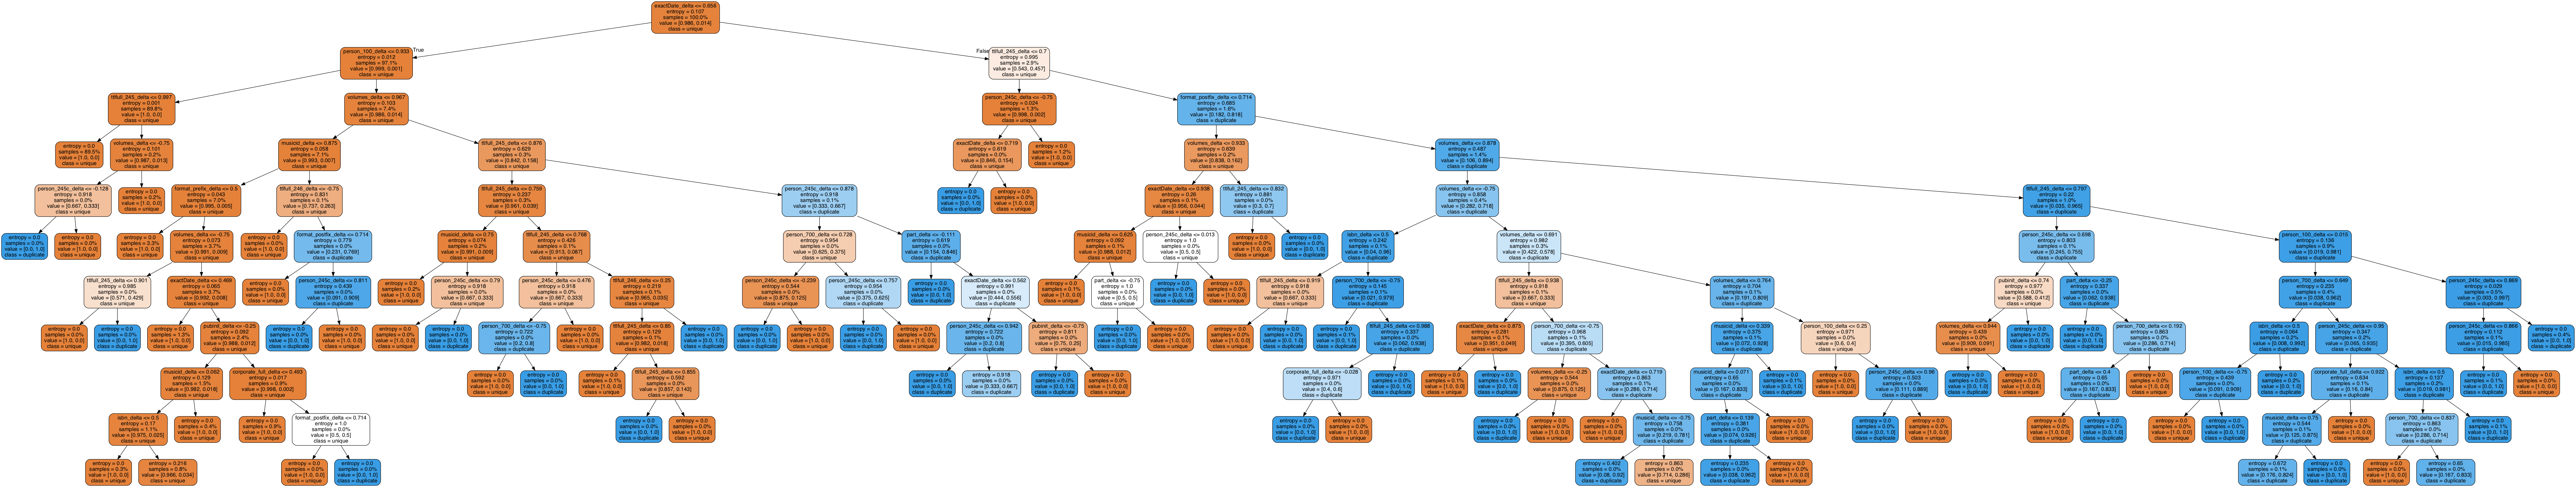

In [13]:
from IPython.display import Image
Image(decision_tree_png)

Counting the layers of the tree confirms its depth of 20.

### Performance Measurement of Decision Tree

The confusion matrix is used for testing the performance of the classifier [[ConfMatr](./A_References.ipynb#confmatr)], see [figure 1](#f_confusion_matrix). In the confusion matrix, the records of class duplicate are the positive case, while the records of class unique are the negative case. The true negatives (uniques) and the true positives (duplicates) are the correctly classified predictions, where the notion "correct" refers to correct according to the classification of the provided test data set. The false negatives are the records that the model predicts as uniques but the reality of the test data classifies as duplicates. The false positives are the records that the model predicts as duplicates but the reality of the test data classifies as uniques.

In [14]:
from sklearn.metrics import confusion_matrix

y_pred_dt = dt_best.predict(X_te)

confusion_matrix(y_te, y_pred_dt)

array([[20627,     9],
       [   18,   277]])

Looking at the numbers, above, the specific numbers depend on the parameters used for the model calculation and on the number of records used for training and for testing.
- The left number in the first row is the true negative ($tn$) of the confusion matrix while ...
- the right number in the first row is the false positive ($fp$).
- The left number in the second row is the false negative ($fn$) and ...
- the right number in the second row is the true positive ($tp$).

<center>
    <b>Figure 1</b><a id='f_confusion_matrix'></a> Confusion matrix based on [<a href='./A_References.ipynb#confmatr'>ConfMatr</a>].
    <img src="./documentation/confusion_matrix.png" style="width: 600px;"/></p>
</center>

The explicit assessment of the specific figures will be done in [Overview and Summary](./0_OverviewSummary.ipynb) depending on the specific parameters used for a run.

In [15]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score

print('Score {:.3f}%'.format(100*dt_best.score(X_te, y_te)))
print('Area under the curve {:.3f}% - accuracy {:.3f}% - precision {:.3f}% - recall {:.3f}%'.format(
    100*roc_auc_score(y_te, y_pred_dt),
                100*accuracy_score(y_te, y_pred_dt),
                100*precision_score(y_te, y_pred_dt),
                100*recall_score(y_te, y_pred_dt)
               ))

Score 99.871%


Area under the curve 96.927% - accuracy 99.871% - precision 96.853% - recall 93.898%


The confusion matrix allows for calculating some characteristic numbers [[ConfMatr](./A_References.ipynb#confmatr)].
- The accuracy is the ratio of the correctly predicted cases and the total number of records in the data $$acc = \frac{tp+tn}{p+n}.$$
The accuracy is equal to the score value in the output above.
- The precision is the ratio of true positives and the number of records of class duplicate in the data $$ppv = \frac{tp}{tp+fp}.$$
- The recall (or sensitivity) is the ratio of true positives and the number of real positive records in the data $$tpr = \frac{tp}{tp+fn}.$$

The prediction $y_{pred}$ of a classifier for a record of the training or test data set is based on the prediction probability $y_{pred}^{probability}$, a tuple of two numbers in the closed interval from 0 to 1 where the sum of the two tuple elements is equal to 1
$$y_{pred}^{probability} = (a, b) \texttt{ with } a, b \in [0, 1] \texttt{ and } a+b = 1.$$
Function $\texttt{.predict}()$ of the classifer uses a value of 0.5 to assign a record uniquely to either class. This value of 0.5 is the default threshold of the classifier. To get $y_{pred}^{probability}$, the model's function $\texttt{.predict}\_\texttt{proba}()$ can be called. With the resulting raw probability tuple, the threshold can be adjusted. The effect of varying the threshold is a shift in the allocations of records in the quadrant of the confusion matrix. This is equivalent to a change of the characteristic numbers. Modifying the threshold value allows for tuning a model with the goal of maximizing a desired characteristic number. As an example, the precision may be maximized. The increase of one characteristic number will decrease the other characteristic numbers like the accuracy, though.

In [16]:
y_proba = pd.Series(dt_best.predict_proba(X_te)[:,1])
y_proba[(y_proba>0) & (y_proba<1)] # Empty Series means no result

19       0.034351
366      0.034351
383      0.034351
400      0.920000
532      0.034351
           ...   
20559    0.034351
20610    0.034351
20742    0.034351
20878    0.034351
20891    0.034351
Length: 184, dtype: float64

Unfortunately, the Decision Tree Classifier exclusively predicts probability tuples of kind $(0,1)$ for duplicates and $(1,0)$ for uniques. Therefore, the effect of changing threshold cannot be illustrated with this classifier. This will be made up below with the Random Forests classifier.

With the notion of the threshold, one more characteristic number can be explained. The roc auc (area under the receiver operating characteristic curve) is derived from a graphical plot of the fraction of the true positive rate $tpr$ versus the false positive rate
$$fpr = \frac{fp}{fp+tn}$$
at various settings of the threshold [[rocauc](./A_References.ipynb#rocauc)]. The value of the roc auc may vary between 0 and 1. If a classifier does not generate any relevant information, its value is 0.5. The closer the roc auc value is to 1, the better is the prediction quality of the classifier.

With these characterstic numbers derived from the confusion matrix, the prediction performance of a classifier is quantified. The comparison of the characteristic numbers of different classifiers will produce a ranking in chapter [Overview and Summary](./0_OverviewSummary.ipynb). The ranking metric for assessing the overall best model of all calculated models is to remain the accuracy. If the accuracy happens to be equal for two different models, then the roc auc will be considered for a second metric.

This kind of fine ranking with a another metric number has to be pointed out. Within a model, the best classifier is ranked first using the accuracy score. When comparing and ranking the models among each other, the metric for assessing the rank remains the accuracy score. Adding the roc auc value for fine ranking moved metric numbers like precision and recall into additional consideration. This augmented information on the model's performance is the motivation for this kind of fine ranking. Unfortunately, there is no garantee that the roc auc value as a balanced mixture of several scoring values holds the best possible value for the model with the best accuracy. This weakness will be accepted for this capstone project, though.

In [17]:
# Extend display to number of columns of DataFrame
pd.options.display.max_columns = len(df_attribute_with_sim_feature.columns)

df_attribute_with_sim_feature.iloc[idx_te].sort_index().sample(n=5)

duplicates  coordinate_E_delta coordinate_E_x coordinate_E_y  \
56248           0                -1.0                                 
76391           0                -1.0                                 
72388           0                -1.0                                 
24207           0                -1.0                                 
17466           0                -1.0                                 

       coordinate_N_delta coordinate_N_x coordinate_N_y  corporate_full_delta  \
56248                -1.0                                                -1.0   
76391                -1.0                                                -1.0   
72388                -1.0                                                -1.0   
24207                -1.0                                                -0.5   
17466                -1.0                                                -1.0   

                                        corporate_full_x corporate_full_y  \
56248                                                                       
76391                                                                       
72388                                                                       
24207  interkantonale lehrmittelzentrale (luzern), st...                    
17466                                                                       

       doi_delta doi_x doi_y  edition_delta edition_x edition_y  \
56248       -1.0                       -1.0                       
76391       -1.0                       -1.0                       
72388       -1.0                       -1.0                       
24207       -1.0                       -1.0                       
17466       -1.0                       -1.0                       

       exactDate_delta exactDate_x exactDate_y  format_postfix_delta  \
56248            0.625    2005aaaa    2015uuuu              0.111111   
76391            0.250    1900aaaa    2011uuuu              0.428571   
72388            0.500    2005aaaa    uuuuuuuu              0.428571   
24207            0.500    19949999    uuuuuuuu              0.428571   
17466            0.250    2004aaaa    1987uuuu              0.111111   

      format_postfix_x format_postfix_y  format_prefix_delta format_prefix_x  \
56248           010300           020000                  0.0              vm   
76391           010200           020000                  0.0              mu   
72388           010300           040100                  0.0              vm   
24207           020000           010000                  1.0              bk   
17466           010100           020000                  0.0              cf   

      format_prefix_y  isbn_delta           isbn_x  \
56248              bk         0.0               []   
76391              bk         0.0               []   
72388              mu         1.0               []   
24207              bk         1.0               []   
17466              bk         0.0  [3-89760-233-4]   

                                                  isbn_y  ismn_delta ismn_x  \
56248  [978-0-14-310771-2 (paperback), 0-14-310771-2 ...        -1.0          
76391                                [978-3-936438-35-2]        -1.0          
72388                                                 []        -1.0          
24207                                                 []        -1.0          
17466                                                 []        -1.0          

      ismn_y  musicid_delta musicid_x musicid_y  part_delta part_x part_y  \
56248                  -1.0                            -1.0                 
76391                  -0.5     10425                  -0.5             4   
72388                  -0.5     99036                  -1.0                 
24207                  -1.0                            -0.5           6 6   
17466                  -1.0                            -1.0                 

       person_100_delta            person_100_x pe

In the confusion matrix, the false positives and the false negatives are the wrongly predicted records. One way of tuning a classifier may be using different kinds of similarity metrics for an attribute. It is crucial to look at the wrongly predicted records to get an idea on the effect of the similarity metrics used. This analysis with an improvement of the data records has been done iteratively in the course of the capstone project. Some analysis will be illustrated in chapter [Overview and Summary](./0_OverviewSummary.ipynb). To do so, all wrongly predicted records need to be stored in order to hand them over to the summary chapter. This is done with the help of a specific library function $\texttt{.add}\_\texttt{wrong}\_\texttt{predictions}()$.

In [18]:
import results_saving_funcs as rsf

idx = {}
idx['true_predicted_uniques'], idx['true_predicted_duplicates'], idx['false_predicted_uniques'], idx['false_predicted_duplicates'] = raf.get_confusion_matrix_indices(y_te, y_pred_dt)

wrong_prediction_groups = ['false_predicted_uniques', 'false_predicted_duplicates']

for i in wrong_prediction_groups :
    rsf.add_wrong_predictions(path_goldstandard, 
                              dt, i, df_attribute_with_sim_feature.iloc[idx_te].iloc[idx[i]])

The performance measurement described in this subsection will be repeated for all the models to come. The process will focus exclusively on the code and will leave out any additional description.

## Decision Tree Classifier with Cross-Validation

In order to reach a model with a strong statistical stability, cross-validation can be used when training the model. This section will use an object $\texttt{GridSearchCV}$ from scikit-learn for this purpose.

### Train/Test Split for Decision Tree CV

When doing cross-validation, the training data is split into training and validation data by the $\texttt{GridSearchCV}$ object from scikit-learn. Therefore, it is sufficient to split the original data into a train and a test data set without any additional splitting of the train data.

In [19]:
X_tr, _, X_te, y_tr, _, y_te, idx_tr, _, idx_te = cff.split_feature_target(
    df_labelled_feature_matrix, 'train_test')

X_tr[:5], y_tr[:5], idx_tr[:5]

(array([[-1.        , -1.        , -1.        , -1.        , -1.        ,
          0.375     ,  1.        ,  0.42857143,  1.        , -1.        ,
         -1.        , -1.        ,  0.59267881, -1.        , -0.5       ,
         -0.5       , -1.        ,  0.52393162, -1.        , -0.5       ],
        [-1.        , -1.        , -0.5       , -1.        , -1.        ,
          0.25      ,  0.        ,  0.11111111,  1.        , -1.        ,
         -1.        , -1.        , -0.5       ,  0.56565657, -0.5       ,
          0.30112045, -1.        ,  0.78571429, -1.        ,  0.        ],
        [-1.        , -1.        , -1.        , -1.        , -1.        ,
          0.25      ,  1.        ,  0.42857143,  0.        , -1.        ,
         -1.        , -0.5       , -0.5       ,  0.46666667,  0.50483281,
         -0.5       , -1.        ,  0.62225886, -1.        ,  0.51111111],
        [-1.        , -1.        , -1.        , -1.        , -1.        ,
          0.25      ,  0.        , 

In [20]:
print(X_tr.shape, y_tr.shape, X_te.shape, y_te.shape)
print('The test data set holds {:d} records of uniques and {:d} records of duplicates.'.format(
    len(y_te[y_te==0]), len(y_te[y_te==1])))

(83724, 20) (83724,) (20931, 20) (20931,)
The test data set holds 20636 records of uniques and 295 records of duplicates.


### Model Training for Decision Tree CV

The grid search for Decision Tree classifier with cross-validation will be done with the same parameter space like for Decision Tree classifier without cross-validation. In this way, the effect of cross-validation will become obvious.

In [21]:
from sklearn.model_selection import GridSearchCV
import numpy as np

# Create cross-validation object with DecisionTreeClassifer
grid_cv = GridSearchCV(DecisionTreeClassifier(random_state=0),
                       param_grid = parameter_dictionary, cv=5
                       , verbose=1
                      )

# Fit estimator
grid_cv.fit(X_tr, y_tr)

# Get the results with 'cv_results_', get parameters with their scores
params = pd.DataFrame(grid_cv.cv_results_['params'])
scores = pd.DataFrame(grid_cv.cv_results_['mean_test_score'], columns=['accuracy_val'])
log_scores = pd.DataFrame(-np.log(1-grid_cv.cv_results_['mean_test_score']), columns=['log_accuracy_val'])
scores_std = pd.DataFrame(grid_cv.cv_results_['std_test_score'], columns=['std_accuracy_val'])

# Create a DataFrame of (parameters, score, std) pairs
df_test_scores_dtcv = params.merge(scores, how='inner', left_index=True, right_index=True)
df_test_scores_dtcv = df_test_scores_dtcv.merge(
    scores_std, how='inner', left_index=True, right_index=True).sort_values(
    'accuracy_val', ascending=False)
df_test_scores_dtcv = df_test_scores_dtcv.merge(
    log_scores, how='inner', left_index=True, right_index=True)

Fitting 5 folds for each of 76 candidates, totalling 380 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done 380 out of 380 | elapsed:  1.1min finished


In [22]:
df_test_scores_dtcv.sort_values(by='accuracy_val', ascending=True)

class_weight criterion  max_depth  accuracy_val  std_accuracy_val  \
58     balanced   entropy        6.0      0.985631          0.002830   
57     balanced   entropy        4.0      0.985966          0.002391   
38     balanced      gini        4.0      0.989633          0.004722   
39     balanced      gini        6.0      0.990576          0.002288   
59     balanced   entropy        8.0      0.992177          0.001251   
..          ...       ...        ...           ...               ...   
49     balanced      gini       26.0      0.998722          0.000317   
51     balanced      gini       30.0      0.998722          0.000317   
50     balanced      gini       28.0      0.998722          0.000317   
53     balanced      gini       40.0      0.998722          0.000317   
52     balanced      gini       35.0      0.998722          0.000317   

    log_accuracy_val  
58          4.242707  
57          4.266260  
38          4.569091  
39          4.664517  
59          4.850646  
..               ...  
49          6.662455  
51          6.662455  
50          6.662455  
53          6.662455  
52          6.662455  

[76 rows x 6 columns]

The validation accuracy can be plotted as a function of the tree depth.

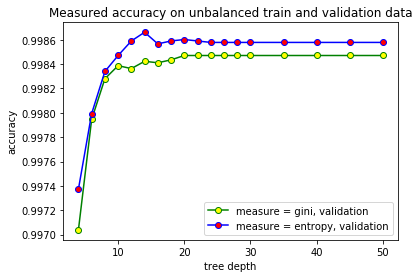

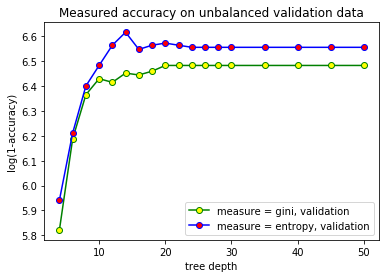

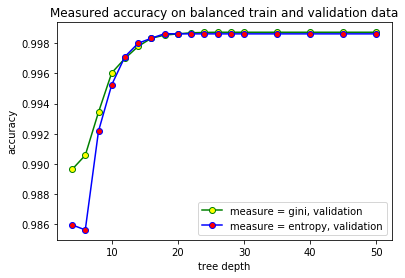

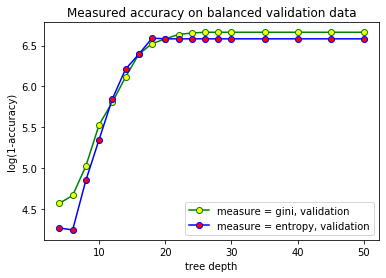

In [23]:
ts_dict = {}

# Reorder on index for x-axis
df_test_scores_dtcv.sort_index(inplace=True)

for kow in parameter_dictionary['class_weight']:
    ts_dict['unbalanced' if kow is None else kow] = [
        ts for ts in df_test_scores_dtcv.to_dict('records')
            if ts['class_weight'] == kow]

for kow in parameter_dictionary['class_weight'] :
    kind_of_weight = 'unbalanced' if kow is None else kow
    # Validation data plot
    plt = raf.plot_accuracy(parameter_dictionary, ts_dict[kind_of_weight], 'accuracy_val')
    plt.ylabel('accuracy')
    plt.title(f'Measured accuracy on {kind_of_weight} train and validation data')
    plt.legend()
    plt.show()
    
    # Validation data plot
    plt = raf.plot_accuracy(parameter_dictionary, ts_dict[kind_of_weight], 'log_accuracy_val')
    plt.ylabel('log(1-accuracy)')
    plt.title(f'Measured accuracy on {kind_of_weight} validation data')
    plt.legend()
    plt.show()

For the $\texttt{GridSearchCV}$ object, the best estimator can be retrieved with the help of attribute $\texttt{best}\_\texttt{estimator}\_$. The parameters for the best estimator tree are shown below. They confirm the graphs above.

In [24]:
dtcv_best = grid_cv.best_estimator_
dtcv_best

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=26, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

Let's have a look at the tree of the best estimator.

In [25]:
# Path for Decision Tree
decision_tree_cv_dot = os.path.join(path_tree_graphics, 'decision_tree_cv.dot')
decision_tree_cv_png = os.path.join(path_tree_graphics, 'decision_tree_cv.png')

# Export decision tree
dot_data = export_graphviz(
    dtcv_best, out_file=decision_tree_cv_dot,
    feature_names=df_labelled_feature_matrix.drop(columns=['duplicates']).columns,
    class_names=['unique', 'duplicate'],
    filled=True, rounded=True, proportion=True
)

# Generate image in .png format
! dot -Tpng $decision_tree_cv_dot -o $decision_tree_cv_png

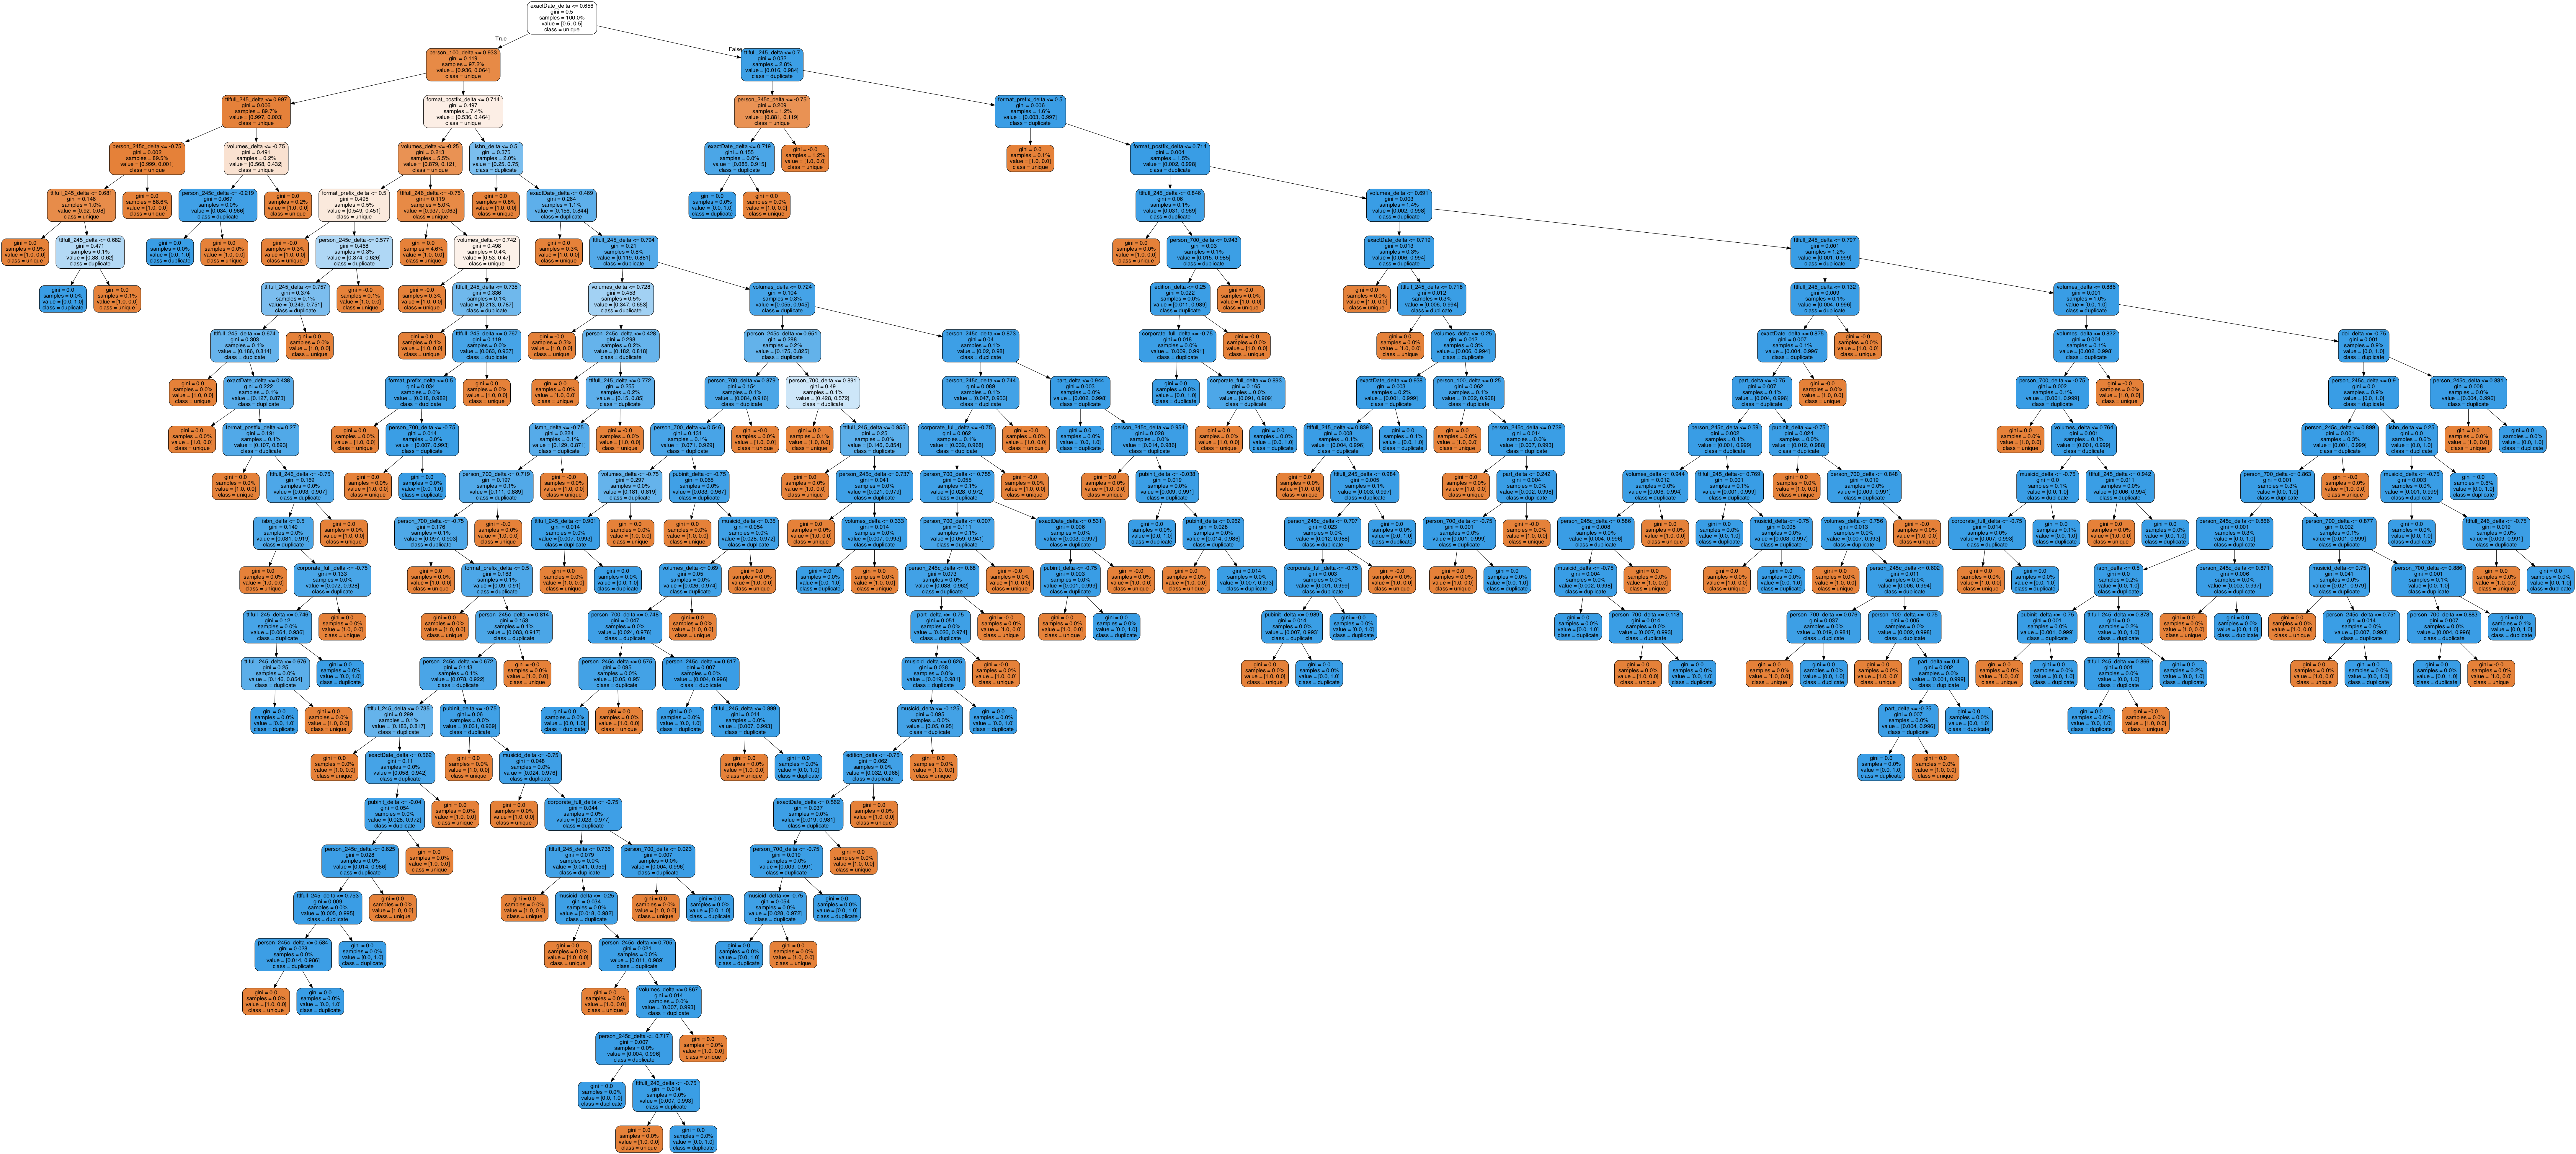

In [26]:
Image(decision_tree_cv_png)

### Performance Measurement of Decision Tree CV

The confusion matrix is used on the test data set for performance analysis, see subsection [Performance Measurement of Decision Tree](#Performance-Measurement-of-Decision-Tree).

In [27]:
y_pred_dtcv = dtcv_best.predict(X_te)

confusion_matrix(y_te, y_pred_dtcv)

array([[20622,    14],
       [   13,   282]])

The scoring figures will be assessed in chapter [Overview and Summary](./0_OverviewSummary.ipynb).

In [28]:
print('Score {:.3f}%'.format(100*dtcv_best.score(X_te, y_te)))
print('Area under the curve {:.3f}% - accuracy {:.3f}% - precision {:.3f}% - recall {:.3f}%'.format(
    100*roc_auc_score(y_te, y_pred_dtcv),
                100*accuracy_score(y_te, y_pred_dtcv),
                100*precision_score(y_te, y_pred_dtcv),
                100*recall_score(y_te, y_pred_dtcv)
               ))

Score 99.871%
Area under the curve 97.763% - accuracy 99.871% - precision 95.270% - recall 95.593%


The prediction probability tuples $y_{pred}^{probability}$ report values of $(1, 0)$ and $(0, 1)$ as seen in subsection [Performance Measurement of Decision Tree](#Performance-Measurement-of-Decision-Tree).

In [29]:
y_proba = pd.Series(dtcv_best.predict_proba(X_te)[:,1])
y_proba[(y_proba>0) & (y_proba<1)] # Empty Series means no result

Series([], dtype: float64)

The last step of the performance measurement subsection is to persist the wrongly classified records for full assessment in chapter [Overview and Summary](./0_OverviewSummary.ipynb).

In [30]:
idx = {}
idx['true_predicted_uniques'], idx['true_predicted_duplicates'], idx['false_predicted_uniques'], idx['false_predicted_duplicates'] = raf.get_confusion_matrix_indices(y_te, y_pred_dtcv)

wrong_prediction_groups = ['false_predicted_uniques', 'false_predicted_duplicates']

for i in wrong_prediction_groups :
    rsf.add_wrong_predictions(path_goldstandard, 
                              dtcv_best, i, df_attribute_with_sim_feature.iloc[idx_te].iloc[idx[i]], '_CV')

## Random Forests

Another Ensemble method is Random Forests. The results of this classifier will be presented in this section.

### Train/Test Split for Random Forests

The train/test split for Random Forests will be done the same way like for the Decision Tree classifier with the goal to have three distinct data sets, one for training, one for validation and one for performance testing.

In [31]:
X_tr, X_val, X_te, y_tr, y_val, y_te, idx_tr, id_val, idx_te = cff.split_feature_target(
    df_labelled_feature_matrix, 'train_validation_test')

X_tr[:5], y_tr[:5], idx_tr[:5]

(array([[-1.        , -1.        , -1.        , -1.        , -1.        ,
          0.375     ,  1.        ,  1.        ,  0.        , -1.        ,
         -1.        , -0.5       , -0.5       ,  0.53717949,  0.49234099,
          0.48232323, -1.        ,  0.57057231, -1.        ,  0.        ],
        [-1.        , -1.        , -1.        , -1.        , -1.        ,
          0.25      ,  1.        ,  0.42857143,  0.        , -1.        ,
         -1.        , -0.5       , -0.5       , -0.5       , -0.5       ,
         -0.5       , -1.        ,  0.56825397, -1.        ,  0.55555556],
        [-1.        , -1.        , -0.5       , -1.        , -1.        ,
          0.5       ,  1.        ,  1.        ,  0.        , -1.        ,
         -1.        , -0.5       , -0.5       , -0.5       , -0.5       ,
          0.41282051, -1.        ,  0.58290694, -0.5       , -0.5       ],
        [-1.        , -1.        , -0.5       , -1.        , -1.        ,
          0.5       ,  1.        , 

In [32]:
print(X_tr.shape, y_tr.shape, X_val.shape, y_val.shape, X_te.shape, y_te.shape)
print('The test data set holds {:d} records of uniques and {:d} records of duplicates.'.format(
    len(y_te[y_te==0]), len(y_te[y_te==1])))

(66979, 20) (66979,) (16745, 20) (16745,) (20931, 20) (20931,)
The test data set holds 20636 records of uniques and 295 records of duplicates.


### Model Training for Random Forests

The parameters for a Random Forests classifier are different to the parameters of the Decision Tree Classifier. This is due to the differences in the algorithms, see the scikit-learn documentation for details.

In [33]:
if execution_mode == 'manual' :
    depths = [18, 20, 22]
    depths.append(None)
    parameter_dictionary = {
        'n_estimators' : [50, 75, 100],
        'max_depth' : depths,
        'class_weight' : [None]
    }
elif execution_mode == 'full' :
    depths = list(range(10, 30, 2))
    depths.append(None)
    parameter_dictionary = {
        'n_estimators' : [8, 16, 32, 64, 128],
        'max_depth' : depths,
        'class_weight' : [None, 'balanced']
    }
elif execution_mode == 'restricted' :
    depths = [18, 20, 22, 24]
    depths.append(None)
    parameter_dictionary = {
        'n_estimators' : [128],
        'max_depth' : depths,
        'class_weight' : [None]
    }
elif execution_mode == 'tune' :
    # Tune random forest classifier
    depths = list(range(16, 27))
    parameter_dictionary = {
        'n_estimators' : list(range(70, 125, 5)),
        'max_depth' : depths,
        'class_weight' : [None, 'balanced']
    }

# Grid of values
grid = cff.generate_parameter_grid(parameter_dictionary)

The grid parameters are ...
n_estimators [8, 16, 32, 64, 128]
max_depth [10, 12, 14, 16, 18, 20, 22, 24, 26, 28, None]
class_weight [None, 'balanced']
 => Number of combinations : 110


In [34]:
from sklearn.ensemble import RandomForestClassifier

# Create random forest
rf = RandomForestClassifier(random_state=0) # Leave impurty measure on default value 'gini'

# Save accuracy on test set
test_scores = []
for params_dict in grid :
    test_scores.append(cff.fit_model_measure_scores(rf, params_dict, X_tr, y_tr, X_val, y_val))

# Save measured accuracies
df_test_scores_rf = pd.DataFrame(test_scores).sort_values('accuracy_val', ascending=False)

Fitting with parameters {'class_weight': None, 'max_depth': 10, 'n_estimators': 8}


 => validation score 99.904%
Fitting with parameters {'class_weight': None, 'max_depth': 10, 'n_estimators': 16}


 => validation score 99.910%
Fitting with parameters {'class_weight': None, 'max_depth': 10, 'n_estimators': 32}


 => validation score 99.916%
Fitting with parameters {'class_weight': None, 'max_depth': 10, 'n_estimators': 64}


 => validation score 99.916%
Fitting with parameters {'class_weight': None, 'max_depth': 10, 'n_estimators': 128}


 => validation score 99.916%
Fitting with parameters {'class_weight': None, 'max_depth': 12, 'n_estimators': 8}


 => validation score 99.940%
Fitting with parameters {'class_weight': None, 'max_depth': 12, 'n_estimators': 16}


 => validation score 99.922%
Fitting with parameters {'class_weight': None, 'max_depth': 12, 'n_estimators': 32}


 => validation score 99.940%
Fitting with parameters {'class_weight': None, 'max_depth': 12, 'n_estimators': 64}


 => validation score 99.934%
Fitting with parameters {'class_weight': None, 'max_depth': 12, 'n_estimators': 128}


 => validation score 99.934%
Fitting with parameters {'class_weight': None, 'max_depth': 14, 'n_estimators': 8}


 => validation score 99.934%
Fitting with parameters {'class_weight': None, 'max_depth': 14, 'n_estimators': 16}


 => validation score 99.928%
Fitting with parameters {'class_weight': None, 'max_depth': 14, 'n_estimators': 32}


 => validation score 99.940%
Fitting with parameters {'class_weight': None, 'max_depth': 14, 'n_estimators': 64}


 => validation score 99.934%
Fitting with parameters {'class_weight': None, 'max_depth': 14, 'n_estimators': 128}


 => validation score 99.928%
Fitting with parameters {'class_weight': None, 'max_depth': 16, 'n_estimators': 8}


 => validation score 99.934%
Fitting with parameters {'class_weight': None, 'max_depth': 16, 'n_estimators': 16}


 => validation score 99.922%
Fitting with parameters {'class_weight': None, 'max_depth': 16, 'n_estimators': 32}


 => validation score 99.952%
Fitting with parameters {'class_weight': None, 'max_depth': 16, 'n_estimators': 64}


 => validation score 99.940%
Fitting with parameters {'class_weight': None, 'max_depth': 16, 'n_estimators': 128}


 => validation score 99.940%
Fitting with parameters {'class_weight': None, 'max_depth': 18, 'n_estimators': 8}


 => validation score 99.922%
Fitting with parameters {'class_weight': None, 'max_depth': 18, 'n_estimators': 16}


 => validation score 99.946%
Fitting with parameters {'class_weight': None, 'max_depth': 18, 'n_estimators': 32}


 => validation score 99.946%
Fitting with parameters {'class_weight': None, 'max_depth': 18, 'n_estimators': 64}


 => validation score 99.946%
Fitting with parameters {'class_weight': None, 'max_depth': 18, 'n_estimators': 128}


 => validation score 99.928%
Fitting with parameters {'class_weight': None, 'max_depth': 20, 'n_estimators': 8}


 => validation score 99.910%
Fitting with parameters {'class_weight': None, 'max_depth': 20, 'n_estimators': 16}


 => validation score 99.940%
Fitting with parameters {'class_weight': None, 'max_depth': 20, 'n_estimators': 32}


 => validation score 99.946%
Fitting with parameters {'class_weight': None, 'max_depth': 20, 'n_estimators': 64}


 => validation score 99.934%
Fitting with parameters {'class_weight': None, 'max_depth': 20, 'n_estimators': 128}


 => validation score 99.934%
Fitting with parameters {'class_weight': None, 'max_depth': 22, 'n_estimators': 8}


 => validation score 99.928%
Fitting with parameters {'class_weight': None, 'max_depth': 22, 'n_estimators': 16}


 => validation score 99.952%
Fitting with parameters {'class_weight': None, 'max_depth': 22, 'n_estimators': 32}


 => validation score 99.940%
Fitting with parameters {'class_weight': None, 'max_depth': 22, 'n_estimators': 64}


 => validation score 99.946%
Fitting with parameters {'class_weight': None, 'max_depth': 22, 'n_estimators': 128}


 => validation score 99.934%
Fitting with parameters {'class_weight': None, 'max_depth': 24, 'n_estimators': 8}


 => validation score 99.928%
Fitting with parameters {'class_weight': None, 'max_depth': 24, 'n_estimators': 16}


 => validation score 99.946%
Fitting with parameters {'class_weight': None, 'max_depth': 24, 'n_estimators': 32}


 => validation score 99.940%
Fitting with parameters {'class_weight': None, 'max_depth': 24, 'n_estimators': 64}


 => validation score 99.946%
Fitting with parameters {'class_weight': None, 'max_depth': 24, 'n_estimators': 128}


 => validation score 99.934%
Fitting with parameters {'class_weight': None, 'max_depth': 26, 'n_estimators': 8}


 => validation score 99.928%
Fitting with parameters {'class_weight': None, 'max_depth': 26, 'n_estimators': 16}


 => validation score 99.958%
Fitting with parameters {'class_weight': None, 'max_depth': 26, 'n_estimators': 32}


 => validation score 99.940%
Fitting with parameters {'class_weight': None, 'max_depth': 26, 'n_estimators': 64}


 => validation score 99.946%
Fitting with parameters {'class_weight': None, 'max_depth': 26, 'n_estimators': 128}


 => validation score 99.934%
Fitting with parameters {'class_weight': None, 'max_depth': 28, 'n_estimators': 8}


 => validation score 99.928%
Fitting with parameters {'class_weight': None, 'max_depth': 28, 'n_estimators': 16}


 => validation score 99.958%
Fitting with parameters {'class_weight': None, 'max_depth': 28, 'n_estimators': 32}


 => validation score 99.940%
Fitting with parameters {'class_weight': None, 'max_depth': 28, 'n_estimators': 64}


 => validation score 99.946%
Fitting with parameters {'class_weight': None, 'max_depth': 28, 'n_estimators': 128}


 => validation score 99.934%
Fitting with parameters {'class_weight': None, 'max_depth': None, 'n_estimators': 8}


 => validation score 99.928%
Fitting with parameters {'class_weight': None, 'max_depth': None, 'n_estimators': 16}


 => validation score 99.958%
Fitting with parameters {'class_weight': None, 'max_depth': None, 'n_estimators': 32}


 => validation score 99.940%
Fitting with parameters {'class_weight': None, 'max_depth': None, 'n_estimators': 64}


 => validation score 99.946%
Fitting with parameters {'class_weight': None, 'max_depth': None, 'n_estimators': 128}


 => validation score 99.934%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 8}


 => validation score 99.755%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 16}


 => validation score 99.779%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 32}


 => validation score 99.773%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 64}


 => validation score 99.779%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 128}


 => validation score 99.767%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 12, 'n_estimators': 8}


 => validation score 99.815%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 12, 'n_estimators': 16}


 => validation score 99.881%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 12, 'n_estimators': 32}


 => validation score 99.869%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 12, 'n_estimators': 64}


 => validation score 99.881%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 12, 'n_estimators': 128}


 => validation score 99.893%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 14, 'n_estimators': 8}


 => validation score 99.893%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 14, 'n_estimators': 16}


 => validation score 99.928%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 14, 'n_estimators': 32}


 => validation score 99.922%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 14, 'n_estimators': 64}


 => validation score 99.922%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 14, 'n_estimators': 128}


 => validation score 99.934%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 16, 'n_estimators': 8}


 => validation score 99.916%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 16, 'n_estimators': 16}


 => validation score 99.934%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 16, 'n_estimators': 32}


 => validation score 99.940%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 16, 'n_estimators': 64}


 => validation score 99.940%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 16, 'n_estimators': 128}


 => validation score 99.940%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 18, 'n_estimators': 8}


 => validation score 99.934%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 18, 'n_estimators': 16}


 => validation score 99.946%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 18, 'n_estimators': 32}


 => validation score 99.946%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 18, 'n_estimators': 64}


 => validation score 99.940%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 18, 'n_estimators': 128}


 => validation score 99.946%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 20, 'n_estimators': 8}


 => validation score 99.946%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 20, 'n_estimators': 16}


 => validation score 99.952%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 20, 'n_estimators': 32}


 => validation score 99.934%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 20, 'n_estimators': 64}


 => validation score 99.946%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 20, 'n_estimators': 128}


 => validation score 99.946%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 22, 'n_estimators': 8}


 => validation score 99.952%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 22, 'n_estimators': 16}


 => validation score 99.952%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 22, 'n_estimators': 32}


 => validation score 99.946%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 22, 'n_estimators': 64}


 => validation score 99.946%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 22, 'n_estimators': 128}


 => validation score 99.946%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 24, 'n_estimators': 8}


 => validation score 99.946%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 24, 'n_estimators': 16}


 => validation score 99.946%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 24, 'n_estimators': 32}


 => validation score 99.946%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 24, 'n_estimators': 64}


 => validation score 99.952%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 24, 'n_estimators': 128}


 => validation score 99.946%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 26, 'n_estimators': 8}


 => validation score 99.946%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 26, 'n_estimators': 16}


 => validation score 99.940%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 26, 'n_estimators': 32}


 => validation score 99.946%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 26, 'n_estimators': 64}


 => validation score 99.946%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 26, 'n_estimators': 128}


 => validation score 99.946%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 28, 'n_estimators': 8}


 => validation score 99.946%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 28, 'n_estimators': 16}


 => validation score 99.940%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 28, 'n_estimators': 32}


 => validation score 99.940%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 28, 'n_estimators': 64}


 => validation score 99.946%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': 28, 'n_estimators': 128}


 => validation score 99.946%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 8}


 => validation score 99.946%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 16}


 => validation score 99.940%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 32}


 => validation score 99.940%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 64}


 => validation score 99.946%
Fitting with parameters {'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 128}


 => validation score 99.946%


The Random Forests parameters for the best model are shown below.

In [35]:
best_params = cff.get_best_parameters(test_scores, parameter_dictionary)

# Create a decision tree
rf_best = RandomForestClassifier(n_estimators=best_params['n_estimators'],
                                 max_depth=best_params['max_depth'],
                                 class_weight=best_params['class_weight'],
                                 random_state=0
                                )

# Fit estimator
rf_best.fit(X_tr, y_tr)

The parameters for the best model are ...
n_estimators = 16
max_depth = 26
class_weight = None


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=26, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=16,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

### Performance Measurement of Random Forests

The confusion matrix and the scoring values for the model are shown below.

In [36]:
y_pred_rf = rf_best.predict(X_te)

confusion_matrix(y_te, y_pred_rf)

array([[20628,     8],
       [   16,   279]])

In [37]:
print('Score {:.3f}%'.format(100*rf_best.score(X_te, y_te)))
print('Area under the curve {:.3f}% - accuracy {:.3f}% - precision {:.3f}% - recall {:.3f}%'.format(
    100*roc_auc_score(y_te, y_pred_rf),
                100*accuracy_score(y_te, y_pred_rf),
                100*precision_score(y_te, y_pred_rf),
                100*recall_score(y_te, y_pred_rf)
               ))

Score 99.885%
Area under the curve 97.269% - accuracy 99.885% - precision 97.213% - recall 94.576%


As described and expected in subsection [Performance Measurement of Decision Tree](#Performance-Measurement-of-Decision-Tree), the prediction probability tuples $y_{pred}^{probability}$ report values within the open interval $(0, 1)$.

In [38]:
y_proba = pd.Series(rf_best.predict_proba(X_te)[:,1])
rf_best.predict_proba(X_te)[(y_proba>0) & (y_proba<1)]

array([[0.625     , 0.375     ],
       [0.875     , 0.125     ],
       [0.0625    , 0.9375    ],
       [0.875     , 0.125     ],
       [0.875     , 0.125     ],
       [0.1875    , 0.8125    ],
       [0.375     , 0.625     ],
       [0.9375    , 0.0625    ],
       [0.9375    , 0.0625    ],
       [0.75      , 0.25      ],
       [0.9375    , 0.0625    ],
       [0.0625    , 0.9375    ],
       [0.375     , 0.625     ],
       [0.9375    , 0.0625    ],
       [0.9375    , 0.0625    ],
       [0.875     , 0.125     ],
       [0.8125    , 0.1875    ],
       [0.0625    , 0.9375    ],
       [0.0625    , 0.9375    ],
       [0.8125    , 0.1875    ],
       [0.6875    , 0.3125    ],
       [0.9375    , 0.0625    ],
       [0.0625    , 0.9375    ],
       [0.9375    , 0.0625    ],
       [0.0625    , 0.9375    ],
       [0.9375    , 0.0625    ],
       [0.9375    , 0.0625    ],
       [0.9375    , 0.0625    ],
       [0.9375    , 0.0625    ],
       [0.9375    , 0.0625    ],
       [0.

Changing the threshold away from its default value results in modifyed values of the confusion matrix and of the scoring values, as described in subsection [Performance Measurement of Decision Tree](#Performance-Measurement-of-Decision-Tree).

In [39]:
threshold = 0.1 # Modify threshold value (default is 0.5) => Tune model
y_pred_threshold = y_proba.apply(lambda x: 1.0 if x >= threshold else 0.0)
confusion_matrix(y_te, y_pred_threshold)

array([[20565,    71],
       [    6,   289]])

In [40]:
print('Original score with default threshold : {:.3f}% (see above)'.format(100*rf_best.score(X_te, y_te)))
print('Area under the curve {:.3f}% - accuracy {:.3f}% - precision {:.3f}% - recall {:.3f}%'.format(
    100*roc_auc_score(y_te, y_pred_threshold),
                100*accuracy_score(y_te, y_pred_threshold),
                100*precision_score(y_te, y_pred_threshold),
                100*recall_score(y_te, y_pred_threshold)
               ))

Original score with default threshold : 99.885% (see above)
Area under the curve 98.811% - accuracy 99.632% - precision 80.278% - recall 97.966%


Finally, the wrongly predicted records for the Random Forests classifier need to be persisted for final assessment in the summary chapter. The prediction for the default threshold is taken.

In [41]:
idx = {}
idx['true_predicted_uniques'], idx['true_predicted_duplicates'], idx['false_predicted_uniques'], idx['false_predicted_duplicates'] = raf.get_confusion_matrix_indices(y_te, y_pred_rf)

wrong_prediction_groups = ['false_predicted_uniques', 'false_predicted_duplicates']

for i in wrong_prediction_groups :
    rsf.add_wrong_predictions(path_goldstandard, 
                              rf, i, df_attribute_with_sim_feature.iloc[idx_te].iloc[idx[i]])

### Model Interpretation of Random Forests

For Random Forests an attribute is provided which returns an array indicating the importance of each feature. The higher the value, the more important the feature.

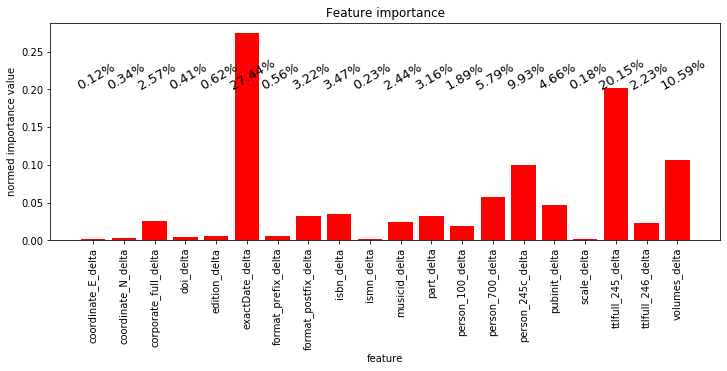

In [42]:
x_ticks = df_labelled_feature_matrix.drop(columns=['duplicates']).columns

plt.figure(figsize=(12,4))
plt.bar(x_ticks, rf_best.feature_importances_, color='red')
for i in range(len(x_ticks)):
    plt.text(i-0.6, 2/10, f'{rf_best.feature_importances_[i]*100:.2f}%',
             color='black', rotation=30, fontsize=13)
plt.xticks(rotation='vertical')
plt.title('Feature importance')
plt.xlabel('feature')
plt.ylabel('normed importance value')
plt.show()

The feature importance of an attribute is correlated to the degree of filling of this attribute, see chapter [Data Analysis](./1_DataAnalysis.ipynb). Apart from that attribute property, its value gives insight into the role, an attribute similarity plays for a record of pairs. It may be different for varying similarity metrics used for one and the same attribute. Therefore the feature importance is an indicator for controlling the similarity metrics used.

## Summary

This chapter has trained the first models for prediction of the class of an unknown data set of test records. The calculated models belong to the family of Ensemble classifiers. The performance of each model has been measured and the way measurement used repeatedly has been introduced and explained with the very first model of Decision Tree Classifier. The models of this chapter will be compared with the results of the Dummy Classifier of chapter [Features Discussion and Dummy Classifier Baseline](./5_FeatureDiscussionDummyBaseline.ipynb) and with all additional models to come. The assessment will be done in chapter [Overview and Summary](./0_OverviewSummary.ipynb).

### Results Handover

The final results will be assessed with the help of the same test data for all three models of this chapter. The train/test split will not be repeated here, as all train/test split calls of this chapter have generated the same test data set, due to fixing $\texttt{random}\_\texttt{state}=0$. The results of this chapter still have to be persisted.

In [43]:
path_results = './results'

rsf.add_result_to_results(path_results,
                          df_test_scores_dt, dt_best, X_te, y_te, y_pred_dt)
rsf.add_result_to_results(path_results,
                          df_test_scores_dtcv, dtcv_best, X_te, y_te, y_pred_dtcv, '_CV')
rsf.add_result_to_results(path_results,
                          df_test_scores_rf, rf_best, X_te, y_te, y_pred_rf)